<a href="https://colab.research.google.com/github/Gabriele90/Biohacker90/blob/main/Creating_a_High_Fidelity_Dataset_from_Experimental_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creating a High Fidelity Dataset from Experimental Data**

In this tutorial, we will look at what is involved in creating a new Dataset from experimental data. As we will see, the mechanics of creating the Dataset object is only a small part of the process. Most real datasets need significant cleanup and QA before they are suitable for training models.

**Setup**

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem
import deepchem
deepchem.__version__

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  20057      0 --:--:-- --:--:-- --:--:-- 20173


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 409kB 4.3MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20201118123653-cp36-none-any.whl size=516160 sha256=86e0e622aca82139320e2d53925fe062ddbb755790dc776f878e6f182ff089cb
  Stored in directory: /root/.cache/pip/wheels/d0/62/46/62d0ff22abaf0778aa1ef94cde4282cb45fcb190f5cdd4ec75
Successfully built deepchem


'2.4.0-rc1.dev'


**Working With Data Files**

Suppose you were given data collected by an experimental collaborator. You would like to use this data to construct a machine learning model.

How do you transform this data into a dataset capable of creating a useful model?

Building models from novel data can present several challenges. Perhaps the data was not recorded in a convenient manner. Additionally, perhaps the data contains noise. This is a common occurrence with, for example, biological assays due to the large number of external variables and the difficulty and cost associated with collecting multiple samples. This is a problem because you do not want your model to fit to this noise.

Hence, there are two primary challenges:

Parsing data
De-noising data
In this tutorial, we will walk through an example of curating a dataset from an excel spreadsheet of experimental drug measurements. Before we dive into this example though, let's do a brief review of DeepChem's input file handling and featurization capabilities.

**Parsing data**
In order to read in the data, we will use the pandas data analysis library.
In order to convert the drug names into smiles strings, we will use pubchempy. This isn't a standard DeepChem dependency, but you can install this library with conda install pubchempy.

In [5]:
!pip install pubchempy

  Created wheel for pubchempy: filename=PubChemPy-1.0.4-cp36-none-any.whl size=13826 sha256=a0238a3216057c92fec9a9d7b8e6528901083e5fb9882ffbfb950b8b25fca9fe
  Stored in directory: /root/.cache/pip/wheels/10/4d/51/6b843681a9a5aef35f0d0fbce243de46f85080036e16118752
Successfully built pubchempy


In [6]:
import os
import pandas as pd
from pubchempy import get_cids, get_compounds

In [9]:
import os
from IPython.display import Image, display
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_screenshot = os.path.join(current_dir, '/content/sample_data')

We see the data of interest is on the second sheet, and contained in columns "TA ID", "N #1 (%)", and "N #2 (%)".

Additionally, it appears much of this spreadsheet was formatted for human readability (multicolumn headers, column labels with spaces and symbols, etc.). This makes the creation of a neat dataframe object harder. For this reason we will cut everything that is unnecesary or inconvenient.

In [10]:
import deepchem as dc
dc.utils.download_url(
    'https://github.com/deepchem/deepchem/raw/master/datasets/Positive%20Modulators%20Summary_%20918.TUC%20_%20v1.xlsx',
    current_dir,
    'Positive Modulators Summary_ 918.TUC _ v1.xlsx'
)

In [11]:
raw_data_file = os.path.join(current_dir, 'Positive Modulators Summary_ 918.TUC _ v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Metric #1 (-120 mV Peak),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
1,TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
2,1,1-A02,Penicillin V Potassium,-12.8689,6.74705,14.1193,-10.404,-18.1929
3,2,1-A03,Mycophenolate Mofetil,-12.8689,6.74705,14.1193,-12.4453,-11.7175
4,3,1-A04,Metaxalone,-12.8689,6.74705,14.1193,-8.65572,-17.7753


Note that the actual row headers are stored in row 1 and not 0 above.

In [12]:
# remove column labels (rows 0 and 1), as we will replace them
# only take data given in columns "TA ID" "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [2, 6, 7]]

# reset the index so we keep the label but number from 0 again
raw_data.reset_index(inplace=True)

## rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

Preview cleaner dataframe

In [13]:
raw_data.loc[raw_data.index[:5]]

,label,drug,n1,n2
0,2,Penicillin V Potassium,-10.404,-18.1929
1,3,Mycophenolate Mofetil,-12.4453,-11.7175
2,4,Metaxalone,-8.65572,-17.7753
3,5,Terazosin·HCl,-11.5048,16.0825
4,6,Fluvastatin·Na,-11.1354,-14.553


This formatting is closer to what we need.

Now, let's take the drug names and get smiles strings for them (format needed for DeepChem).

In [14]:
drugs = raw_data['drug'].values

For many of these, we can retreive the smiles string via the canonical_smiles attribute of the get_compounds object (using pubchempy)

In [21]:
get_compounds(drugs[1], 'name')

[Compound(5281078)]

In [23]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

'CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3CCOCC3)O'


However, some of these drug names have variables spaces and symbols (·, (±), etc.), and names that may not be readable by pubchempy.

For this task, we will do a bit of hacking via regular expressions. Also, we notice that all ions are written in a shortened form that will need to be expanded. For this reason we use a dictionary, mapping the shortened ion names to versions recognizable to pubchempy.

Unfortunately you may have several corner cases that will require more hacking.

In [24]:
import re

ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)
                   
    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

Now let's actually convert all these compounds to smiles. This conversion will take a few minutes so might not be a bad spot to go grab a coffee or tea and take a break while this is running! Note that this conversion will sometimes fail so we've added some error handling to catch these cases below.

In [25]:
smiles_map = {}
for i, compound in enumerate(drugs):
    try:
        smiles_map[compound] = compound_to_smiles(compound)
    except:
        print("Errored on %s" % i)
        continue

Errored on 162
Errored on 303


In [26]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x] if x in smiles_map else None)

# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

,label,drug,n1,n2
0,2,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.404,-18.1929
1,3,CC1=C2COC(=O)C2=C(C(=C1OC)CC=C(C)CCC(=O)OCCN3C...,-12.4453,-11.7175
2,4,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.65572,-17.7753
3,5,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.5048,16.0825
4,6,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.1354,-14.553


Hooray, we have mapped each drug name to its corresponding smiles code.

Now, we need to look at the data and remove as much noise as possible.

**De-noising data**

In machine learning, we know that there is no free lunch. You will need to spend time analyzing and understanding your data in order to frame your problem and determine the appropriate model framework. Treatment of your data will depend on the conclusions you gather from this process.

Questions to ask yourself:

I would like to build a model capable of predicting the affinity of an arbitrary small molecule drug to a particular ion channel protein

For an input drug, data describing channel inhibition
A few hundred drugs, with n=2

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
import numpy as np

Our goal is to build a small molecule model, so let's make sure our molecules are all small. This can be approximated by the length of each smiles string.

Text(0, 0.5, 'probability')

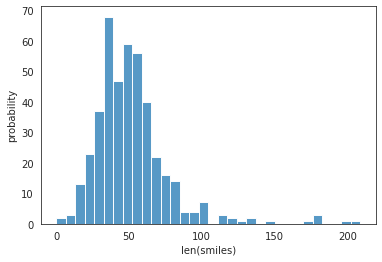

In [28]:
smiles_data['len'] = [len(i) if i is not None else 0 for i in smiles_data['drug']]
smiles_lens = [len(i) if i is not None else 0 for i in smiles_data['drug']]
sns.histplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

Some of these look rather large, len(smiles) > 150. Let's see what they look like.

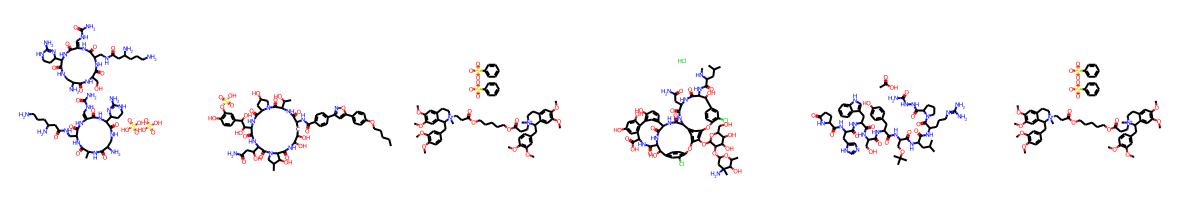

In [29]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

As suspected, these are not small molecules, so we will remove them from the dataset. The argument here is that these molecules could register as inhibitors simply because they are large. They are more likely to sterically blocks the channel, rather than diffuse inside and bind (which is what we are interested in).

The lesson here is to remove data that does not fit your use case.

In [30]:
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

Now, let's look at the numerical structure of the dataset.

First, check for NaNs.

In [31]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
62,NaN,-7.8266
162,-12.8456,-11.4627
175,NaN,-6.61225
187,NaN,-8.23326
233,-8.21781,NaN
262,NaN,-12.8788
288,NaN,-2.34264
300,NaN,-8.19936
301,NaN,-10.4633
303,-5.61374,8.42267



We don't trust n=1, so I will throw these out.

Then, let's examine the distribution of n1 and n2.

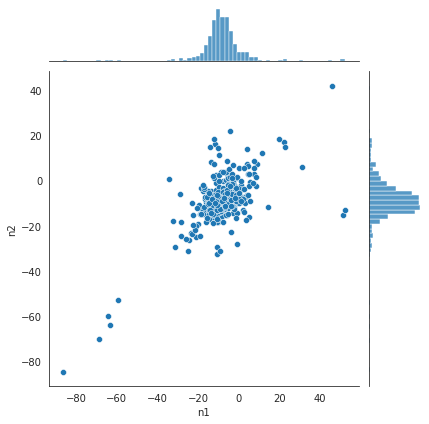

In [32]:
df = smiles_data.dropna(axis=0, how='any')
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot(x='n1', y='n2', data=smiles_data)

We see that most of the data is contained in the gaussian-ish blob centered a bit below zero. We see that there are a few clearly active datapoints located in the bottom left, and one on the top right. These are all distinguished from the majority of the data. How do we handle the data in the blob?

Because n1 and n2 represent the same measurement, ideally they would be of the same value. This plot should be tightly aligned to the diagonal, and the pearson correlation coefficient should be 1. We see this is not the case. This helps gives us an idea of the error of our assay.

Let's look at the error more closely, plotting in the distribution of (n1-n2).

Text(0, 0.5, 'probability')

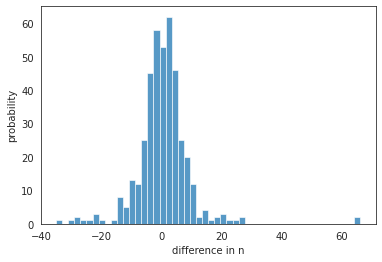

In [33]:
diff_df = df['n1'] - df['n2']

sns.histplot(diff_df)
plt.xlabel('difference in n')
plt.ylabel('probability')

This looks pretty gaussian, let's get the 95% confidence interval by fitting a gaussian via scipy, and taking 2*the standard deviation

In [34]:
from scipy import stats
mean, std = stats.norm.fit(np.asarray(diff_df, dtype=np.float32))
ci_95 = std*2
ci_95

17.75387954711914

Now, I don't trust the data outside of the confidence interval, and will therefore drop these datapoints from df.

For example, in the plot above, at least one datapoint has n1-n2 > 60. This is disconcerting.

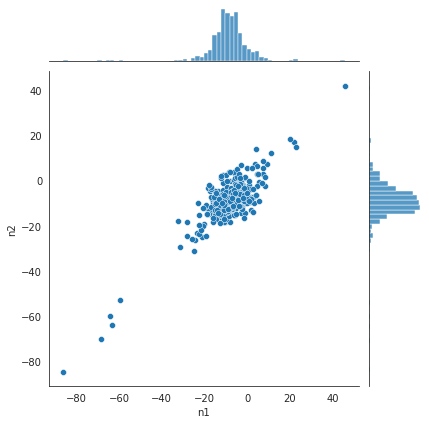

In [35]:
noisy = diff_df[abs(diff_df) > ci_95]
df = df.drop(noisy.index)
sns.jointplot(x='n1', y='n2', data=df)

Now that data looks much better!

So, let's average n1 and n2, and take the error bar to be ci_95.

In [36]:
avg_df = df[['label', 'drug']].copy()
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)


Now, let's look at the sorted data with error bars.

Text(0, 0.5, 'activity')

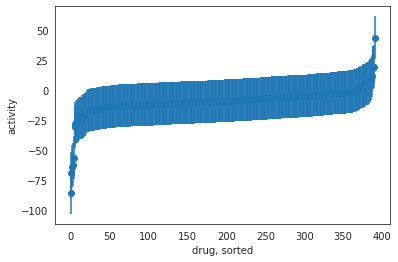

In [37]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

Now, let's identify our active compounds.

In my case, this required domain knowledge. Having worked in this area, and having consulted with professors specializing on this channel, I am interested in compounds where the absolute value of the activity is greater than 25. This relates to the desired drug potency we would like to model.

If you are not certain how to draw the line between active and inactive, this cutoff could potentially be treated as a hyperparameter.

<ErrorbarContainer object of 3 artists>

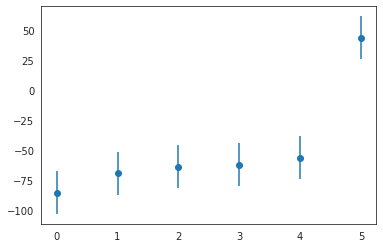

In [38]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']
plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [39]:
print (raw_data.shape, avg_df.shape, len(actives.index))

(430, 5) (392, 3) 6


In summary, we have:

Removed data that did not address the question we hope to answer (small molecules only)
Dropped NaNs
Determined the noise of our measurements
Removed exceptionally noisy datapoints
Identified actives (using domain knowledge to determine a threshold)

**Determine model type, final form of dataset, and sanity load**

Now, what model framework should we use?

Given that we have 392 datapoints and 6 actives, this data will be used to build a low data one-shot classifier (10.1021/acscentsci.6b00367). If there were datasets of similar character, transfer learning could potentially be used, but this is not the case at the moment.

Let's apply logic to our dataframe in order to cast it into a binary format, suitable for classification.

In [40]:
# 1 if condition for active is met, 0 otherwise
avg_df.loc[:, 'active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

Now, save this to file.

In [41]:
avg_df.to_csv('modulators.csv', index=False)

Now, we will convert this dataframe to a DeepChem dataset.

In [42]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='drug', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)


Lastly, it is often advantageous to numerically transform the data in some way. For example, sometimes it is useful to normalize the data, or to zero the mean. This depends in the task at hand.

Built into DeepChem are many useful transformers, located in the deepchem.transformers.transformers base class.

Because this is a classification model, and the number of actives is low, I will apply a balancing transformer. I treated this transformer as a hyperparameter when I began training models. It proved to unambiguously improve model performance.

In [43]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)


Now let's save the balanced dataset object to disk, and then reload it as a sanity check.

In [44]:
dc.utils.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.load_from_disk('balanced_dataset.joblib')